# Seam Carving

In [1]:
import matplotlib.pyplot as plt
import torch
import kornia

/home/calvin/Projects/computer-vision/.venv/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


## Helper Functions

In [2]:
def plot_tensor(tensor, colour='gray'):
    np_array = kornia.utils.tensor_to_image(tensor)
    plt.imshow(np_array, cmap=colour)
    plt.show()

def save_tensor(filename, tensor, colour='gray'):
    np_array = kornia.utils.tensor_to_image(tensor)
    plt.imsave(filename, np_array, cmap=colour)

def img_to_tensor(img):
    img = img[:, :, 0:3]  # take only rgb channels
    img = img.astype('float32') / 255.0  # convert to 0..1 scale
    tensor = kornia.utils.image_to_tensor(img, keepdim=False)
    return tensor

def img_to_gray_tensor(img):
    tensor = img_to_tensor(img)
    return kornia.color.rgb_to_grayscale(tensor)


## Load Images

In [3]:
flatiron_colour = plt.imread('flatiron.jpg')
flatiron_colour = img_to_tensor(flatiron_colour)

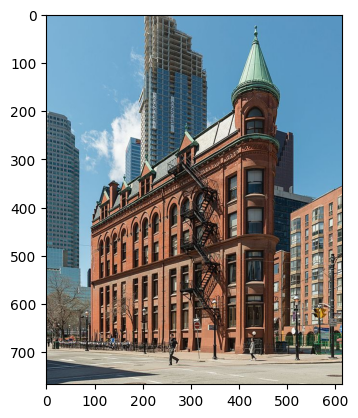

In [4]:
plot_tensor(flatiron_colour , colour='viridis')

In [5]:
print(flatiron_colour.shape)

torch.Size([1, 3, 767, 614])


## Compute Energy

In [6]:
def compute_energy(img):
    gradients = kornia.filters.spatial_gradient(img, mode='sobel', order=1, normalized=True)
    energy = torch.abs(gradients).sum(dim=(1,2)).squeeze()
    return energy

## Compute Scoring Matrix

In [7]:
def compute_scoring(matrix):
    for row in range(1, matrix.shape[0]):
        score_above = torch.nn.functional.pad(matrix[row - 1], (1, 1), 'constant', 1e3)
        min_score_above, _ = score_above.unfold(step=1, size=3, dimension=0).min(dim=1)
        matrix[row] += min_score_above
    return matrix

## Compute Seam

Use a binary matrix to store the seam/path. This has two advantages:
- We can plot the seam as an image
- We can apply the seam as binary mask to the input image to remove that seam. This means we store the seam pixels as `0` and non-seam pixels as `1`.

In [8]:
def compute_seam(scoring):
    last_row = scoring.shape[0] - 1
    seam = torch.ones(scoring.shape, dtype=torch.bool)
    col = scoring[-1].argmin().item()
    seam[-1, col] = 0
    for row in range(last_row, 0, -1):
        score_above = torch.nn.functional.pad(scoring[row - 1], (1, 1), 'constant', 1e3)
        min_step_above = score_above.unfold(step=1, size=3, dimension=0).argmin(dim=1)
        min_step_above -= 1
        col = min_step_above[col] + col
        seam[row - 1, col] = 0
    return seam

## Remove Seam

We can remove a seam from the image by applying the seam as a binary mask to the input image. We then reshape the result matrix to account for the removed column (since we are deleting vertical seams).

In [9]:
def remove_seam(img, seam):
    b, c, h, w = img.shape
    new_img = torch.zeros(b, c, h, w-1)
    for batch in range(b):
        for chan in range(c):
            new_img[batch,chan] = img[batch,chan,seam].reshape(h, w-1)
    return new_img

## Add Seam

We can add a seam simply by duplicating the pixel value at the seam location and shifting the rest of the row over by 1 pixel.

In [10]:
def add_seam(img, seam):
    b, c, h, w = img.shape
    new_img = torch.zeros(b, c, h, w+1)
    for batch in range(b):
        for chan in range(c):
            for row in range(h):
                i = (~seam[row]).nonzero().item()
                new_img[batch, chan, row, :i+1] = img[batch, chan, row, :i+1]
                new_img[batch, chan, row, i+1:] = img[batch, chan, row, i:]
    return new_img

## Seam Carving

In [11]:
def carving_helper(img, target_width):
    while target_width != img.shape[3]:
        energy = compute_energy(img)
        scoring = compute_scoring(energy)
        seam = compute_seam(scoring)
        if target_width < img.shape[3]:
            img = remove_seam(img, seam)
        else:
            img = add_seam(img, seam)
    return img


In [12]:
def seam_carving(img, t_height, t_width):
    _,_,h,w = img.shape
    
    if t_width != w:
        # change width by removing/adding vertical seams
        img = carving_helper(img, t_width)
    if t_height != h:
        # change height by rotating image and then removing/adding seams
        img_flipped = torch.permute(img, (0,1,3,2))
        img_flipped = carving_helper(img_flipped, t_height)
        img = torch.permute(img_flipped, (0,1,3,2))

    return img

## Outputs

Reduce Image Width

In [13]:
flatiron_767x550 = seam_carving(flatiron_colour, t_height=767, t_width=550)
print(flatiron_767x550.shape)

torch.Size([1, 3, 767, 550])


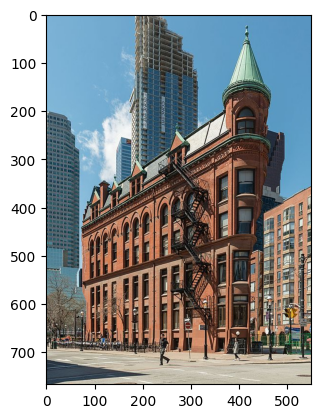

In [14]:
plot_tensor(flatiron_767x550)

Reduce Image Height

In [15]:
flatiron_650x614 = seam_carving(flatiron_colour, t_height=650, t_width=614)
print(flatiron_650x614.shape)

torch.Size([1, 3, 650, 614])


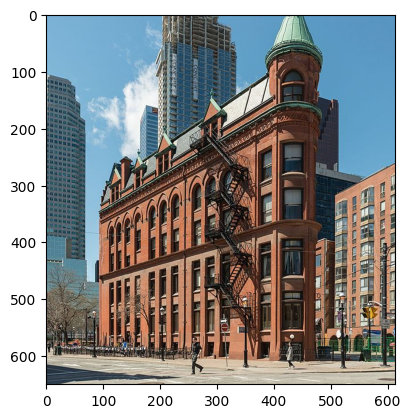

In [16]:
plot_tensor(flatiron_650x614)

Reduce Image Width and Expand Height

In [17]:
flatiron_750x500 = seam_carving(flatiron_colour, t_height=750, t_width=500)
print(flatiron_750x500.shape)

torch.Size([1, 3, 750, 500])


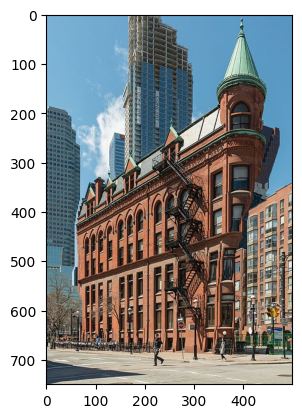

In [18]:
plot_tensor(flatiron_750x500)

In [19]:
save_tensor('flatiron_seam_carving_output_600-600.png', flatiron_750x500)